In [1]:
%load_ext autoreload
%autoreload 2

import numpy  as np
import pandas as pd

from matplotlib import pyplot as plt

from common import hallmark as hm

## Load simulation data from cache

In [2]:
def getdist(path, dist):
    df = pd.read_csv(path, sep='\t')
    return df[dist].values

pf = hm.ParaFrame('cache/Illinois_thermal_w{win:d}/{mag}a{aspin:g}_i{inc:d}/summ_Rh{Rhigh:d}_{freq}.tsv')

for k in set(pf.keys()) - {'path'}:
    globals()[k] = np.unique(pf[k])
    print(k, globals()[k][:16])

mag ['M' 'S']
win [3 4 5]
Rhigh [  1  10  40 160]
inc [ 10  30  50  70  90 110 130 150 170]
freq ['230GHz' '2um' '86GHz']
aspin [-0.94 -0.5   0.    0.5   0.94]


## Sgr A* EHT size constraints (Paper 2, April 7)

In [3]:
eht_fwhm_upper = 95
eht_fwhm_lower = 38

## Sgr A* 230 GHz scattering kernel parameters (Johnson+ 2018)

In [4]:
scat_maj_fwhm = 23.45
scat_min_fwhm = 11.94
scat_pa = 82*(np.pi/180.) #E of N

The EHT upper limit size constraint comes from the LMT-SMT baseline, which on April 7 has a mean position angle of 131 degrees E of N. The lower limit size constraint comes from a combination of LMT-SMT with LMT-ALMA, which on April 7 has a mean position angle of 147 degrees. These baselines are approximately colinear. What is the scattering kernel size in this direction? 

In [5]:
az_lm_uv = np.loadtxt('data/AZ-LM_uv.txt')
aa_lm_uv = np.loadtxt('data/AA-LM_uv.txt')

az_lm_pa = np.pi/2. + -1*np.arctan2(np.mean(-az_lm_uv[:,1]),np.mean(-az_lm_uv[:,0]))
aa_lm_pa = np.pi/2. + -1*np.arctan2(np.mean(aa_lm_uv[:,1]),np.mean(aa_lm_uv[:,0]))

mean_pa = 0.5*(az_lm_pa + aa_lm_pa)

print(az_lm_pa*180/np.pi)
print(aa_lm_pa*180/np.pi)
print(mean_pa*180/np.pi)

131.01469314429673
147.42502762879658
139.21986038654666


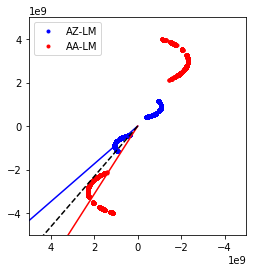

In [6]:
plt.plot(az_lm_uv[:,0],az_lm_uv[:,1],'b.')
plt.plot(-az_lm_uv[:,0],-az_lm_uv[:,1],'b.',label='AZ-LM')
plt.plot([0,1.e10*np.sin(az_lm_pa)],[0,1.e10*np.cos(az_lm_pa)],'b-')


plt.plot(aa_lm_uv[:,0],aa_lm_uv[:,1],'r.')
plt.plot(-aa_lm_uv[:,0],-aa_lm_uv[:,1],'r.',label='AA-LM')
plt.plot([0,1.e10*np.sin(aa_lm_pa)],[0,1.e10*np.cos(aa_lm_pa)],'r-')

plt.plot([0,1.e10*np.sin(mean_pa)],[0,1.e10*np.cos(mean_pa)],'k--')


plt.legend()
plt.xlim([5e9,-5e9])
plt.ylim([-5e9,5e9])
plt.gca().set_aspect('equal')

In [7]:
delta_pa = mean_pa - scat_pa
scat_fwhm = np.sqrt(np.cos(delta_pa)**2 * scat_maj_fwhm**2 + 
                       np.sin(delta_pa)**2 * scat_min_fwhm**2)
print(scat_fwhm)

16.18541731778066


## Option 1: "Deblur" constraints , then compare simulation major axis to lower limit and simulation minor axis to upper limit

In [8]:
#"Deblur" the upper and lower constraints along the baseline axis
eht_fwhm_upper_deblur = np.sqrt(eht_fwhm_upper**2 - scat_fwhm**2)
eht_fwhm_lower_deblur = np.sqrt(eht_fwhm_lower**2 - scat_fwhm**2)
print(eht_fwhm_upper,eht_fwhm_lower)
print(eht_fwhm_upper_deblur,eht_fwhm_lower_deblur)

95 38
93.61106914382127 34.380696128049614


Conservatively, we can demand that the GMRHD frame minor axes must be *smaller* than the EHT maximum size and the GRMHD frame major axes must be *larger* than the EHT minimum size

S spin=-0.94 Rhigh=1 inc=10 is too large!
S spin=-0.94 Rhigh=1 inc=30 is too large!
S spin=-0.94 Rhigh=1 inc=150 is too large!
S spin=-0.94 Rhigh=1 inc=170 is too large!
S spin=-0.5 Rhigh=1 inc=10 is too large!
S spin=-0.5 Rhigh=1 inc=30 is too large!
S spin=-0.5 Rhigh=1 inc=150 is too large!
S spin=-0.5 Rhigh=1 inc=170 is too large!
S spin=0.0 Rhigh=1 inc=10 is too large!
S spin=0.0 Rhigh=1 inc=170 is too large!


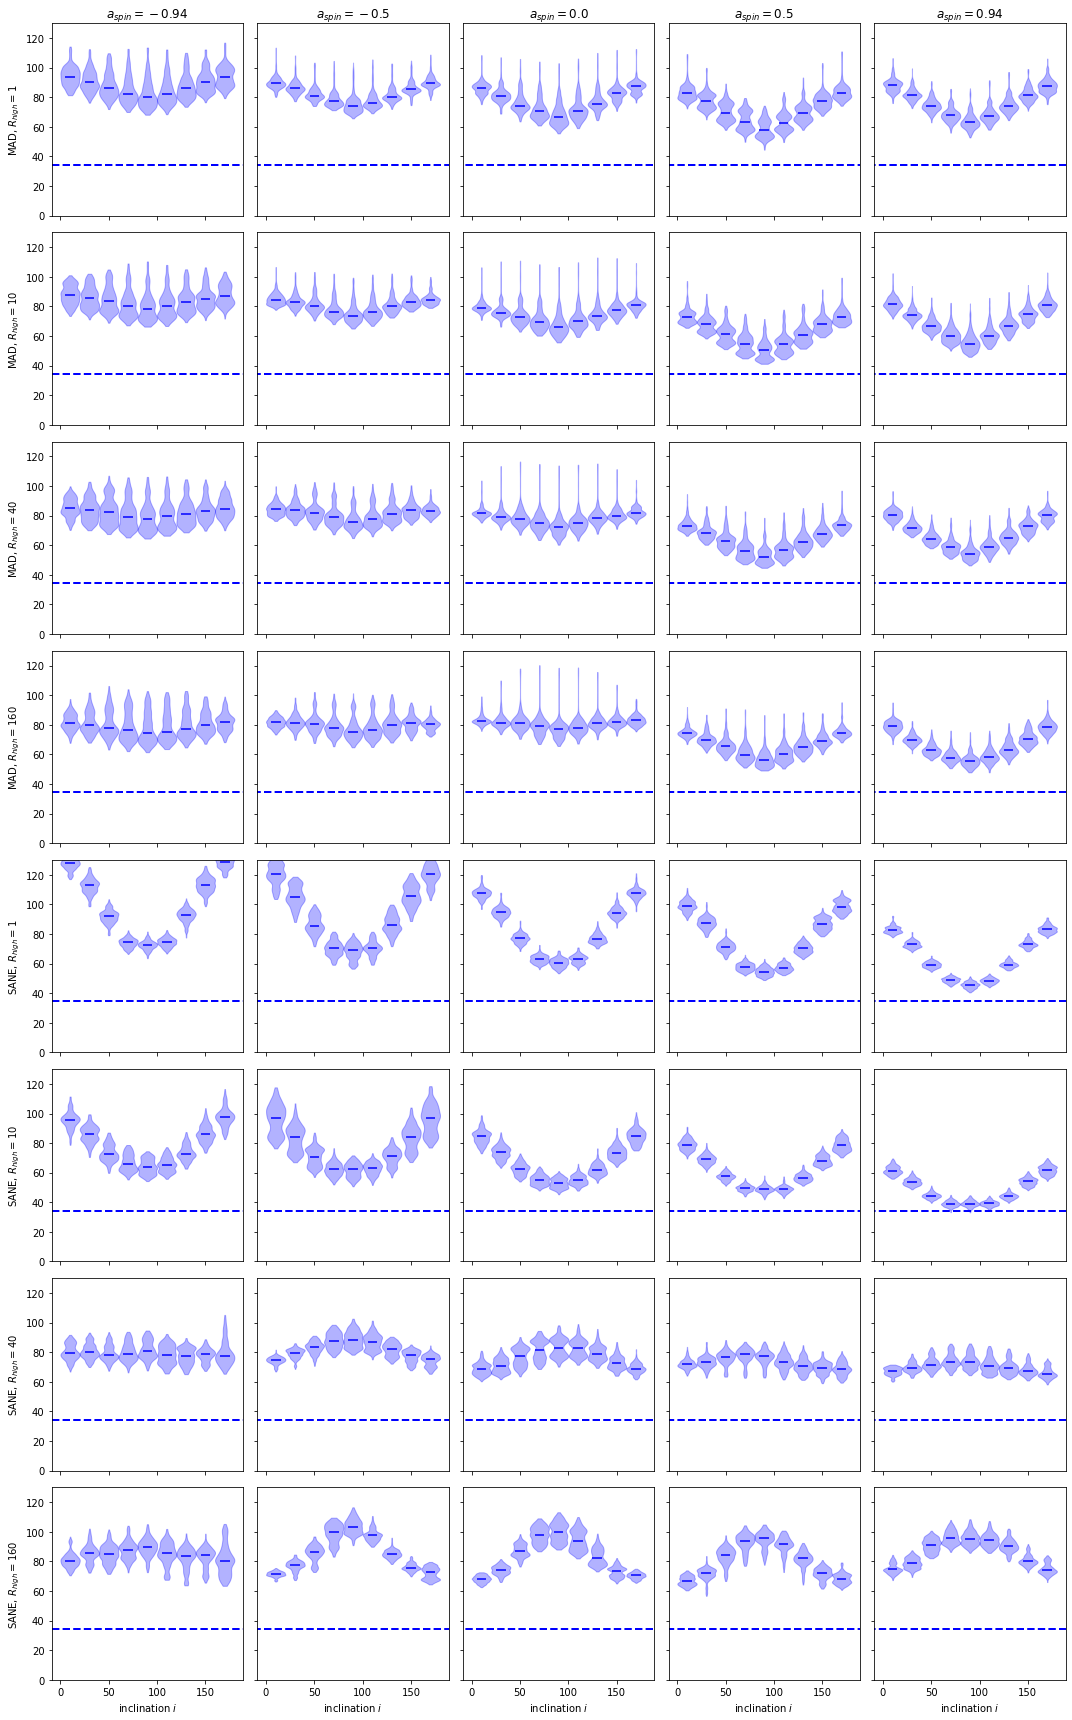

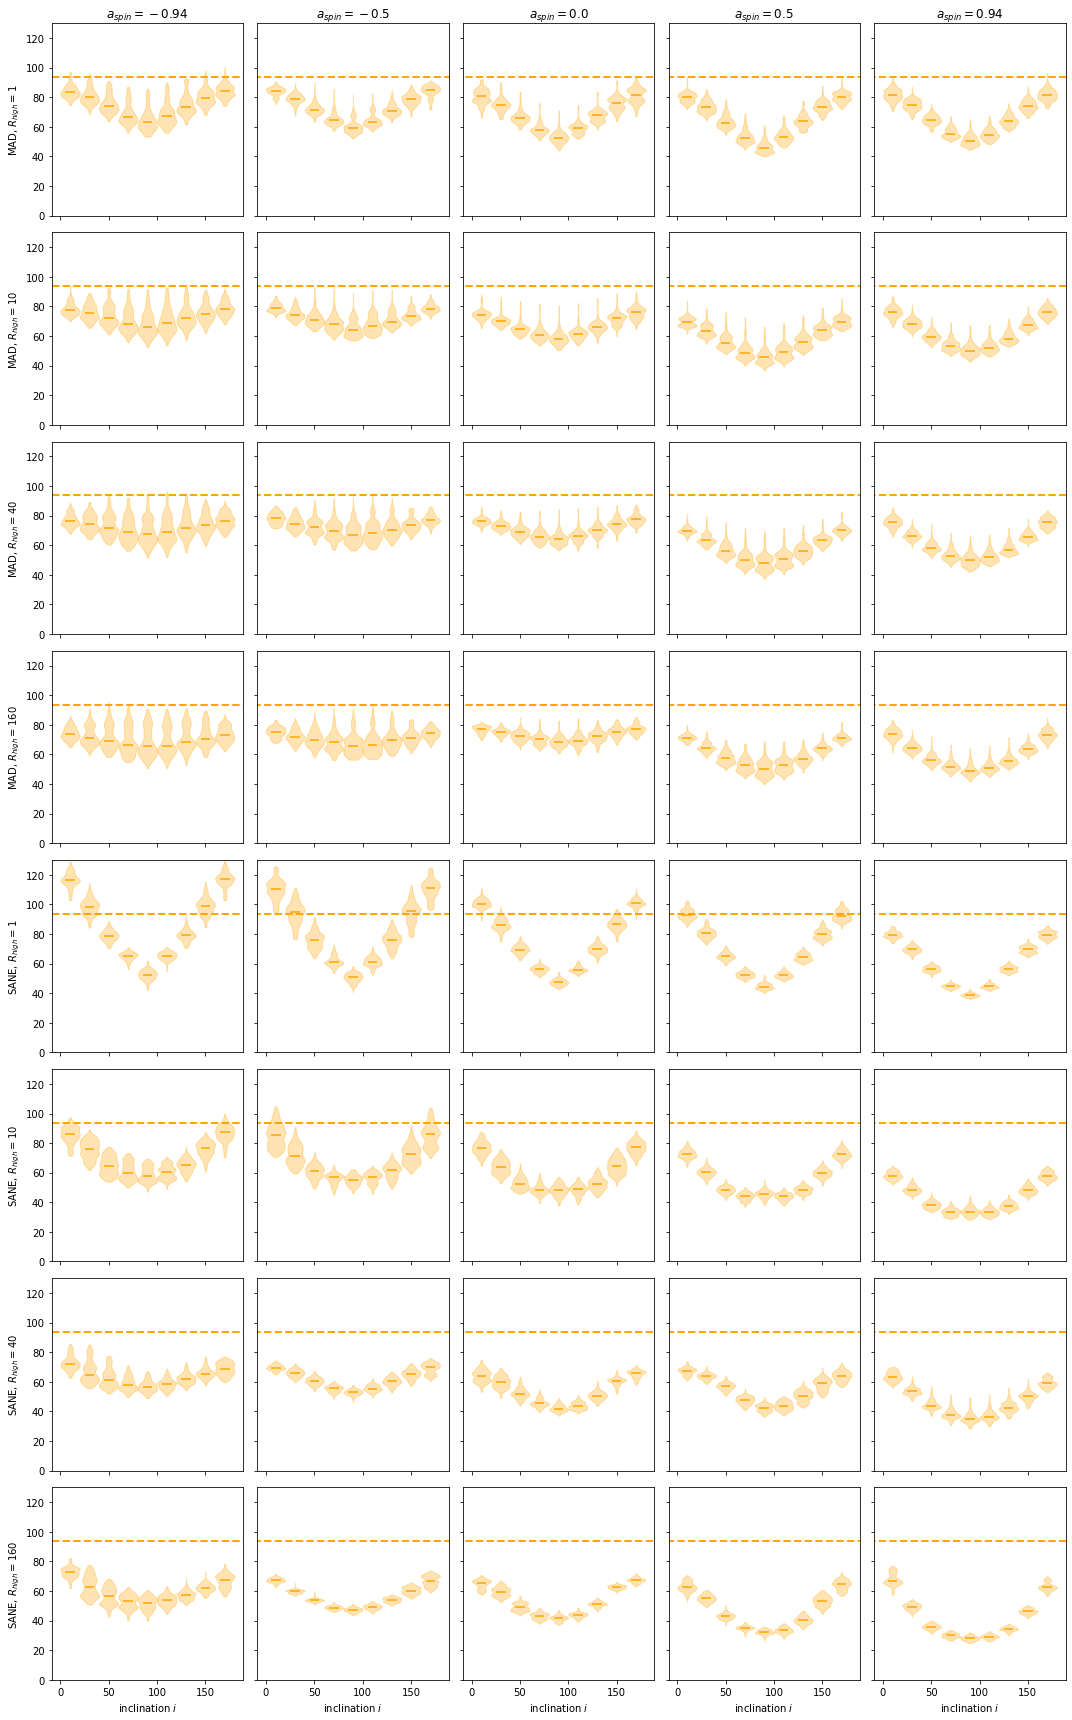

In [9]:
# choose only one window
winselect = 3
for dist in ['major_FWHM', 'minor_FWHM']:
    if dist=='major_FWHM': color='blue'
    if dist=='minor_FWHM': color='orange'

    for freq in ['230GHz']:

        fig, axes = plt.subplots(8, 5, figsize=(15,24), sharex=True, sharey=True)

        for c, a in enumerate(aspin):
            for r1, m in enumerate(mag):
                for r2, Rh in enumerate(Rhigh):
                    #print(a, m, Rh)
                    r = r1 * 4 + r2

                    for w in [winselect]:
                    #for w in win:
                        sel = pf(freq=freq)(aspin=a)(mag=m)(Rhigh=Rh)(win=w)
                        if len(sel) != 9:
                            print('WARNING: too many matchingn tables')
                        dists = [getdist(sel(inc=i).path.iloc[0], dist) for i in inc]
                        violin_parts = axes[r][c].violinplot(dists, positions=inc, widths=20, showmedians=True,showextrema=False)
                        for pc in violin_parts['bodies']:
                            pc.set_facecolor(color)
                            pc.set_edgecolor(color)
                        pc = violin_parts['cmedians']
                        pc.set_facecolor(color)
                        pc.set_edgecolor(color)

                    if dist=='minor_FWHM':
                        axes[r][c].axhline(eht_fwhm_upper_deblur,xmin=-10, xmax=10, 
                                           color=color,ls='--',alpha=1, linewidth=2)
                        for kk,distdat in enumerate(dists):
                            i = inc[kk]
                            if np.median(distdat) > eht_fwhm_upper_deblur: 
                                print(f'{m} spin={a} Rhigh={Rh} inc={i} is too large!')

                        
                    if dist=='major_FWHM':
                        axes[r][c].axhline(eht_fwhm_lower_deblur,xmin=-10, xmax=10, 
                                       color=color,ls='--',alpha=1, linewidth=2)
                        for kk,distdat in enumerate(dists):
                            i = inc[kk]
                            if np.median(distdat) < eht_fwhm_lower_deblur: 
                                print(f'{m} spin={a} Rhigh={Rh} inc={i} is too small!')

                    if r == 0:
                        axes[r][c].set_title(f'$a_{{spin}} = {a}$')
                    elif r == 7:
                        axes[r][c].set_xlabel('inclination $i$')
                    if c == 0:
                        axes[r][c].set_ylabel(f'{"MAD" if m == "M" else "SANE"}, $R_{{high}} = {Rh}$')

                    axes[r][c].set_ylim([0,130])
 
        fig.tight_layout()
        fig.savefig(f'output/plot/sizeconstraint_opt1_{dist}_Illinois_thermal_{freq}.pdf')

## Option 2: "Deblur" constraints , then compare both constraints to the *mean* snapshot size

In [10]:
#"Deblur" the upper and lower constraints along the baseline axis
eht_fwhm_upper_deblur = np.sqrt(eht_fwhm_upper**2 - scat_fwhm**2)
eht_fwhm_lower_deblur = np.sqrt(eht_fwhm_lower**2 - scat_fwhm**2)
print(eht_fwhm_upper,eht_fwhm_lower)
print(eht_fwhm_upper_deblur,eht_fwhm_lower_deblur)

95 38
93.61106914382127 34.380696128049614


For a given GRMHD snapshot, we don't know the sky orientation corresponding to the ~140 degree PA the EHT is measuring the size constraint along. The most conservative thing to do is option 1, where we just demand that the measurement lower limit must be smaller than a given frame major axis and that the measurement upper limit must be greater than a given frame minor axis. In option 2, we look at the (quadrature) mean size for each snapshot and insist that it falls inside the range allowed by the EHT measurement. 

S spin=-0.94 Rhigh=1 inc=10 is too large!
S spin=-0.94 Rhigh=1 inc=30 is too large!
S spin=-0.94 Rhigh=1 inc=150 is too large!
S spin=-0.94 Rhigh=1 inc=170 is too large!
S spin=-0.5 Rhigh=1 inc=10 is too large!
S spin=-0.5 Rhigh=1 inc=30 is too large!
S spin=-0.5 Rhigh=1 inc=150 is too large!
S spin=-0.5 Rhigh=1 inc=170 is too large!
S spin=0.0 Rhigh=1 inc=10 is too large!
S spin=0.0 Rhigh=1 inc=170 is too large!
S spin=0.5 Rhigh=1 inc=10 is too large!
S spin=0.5 Rhigh=1 inc=170 is too large!


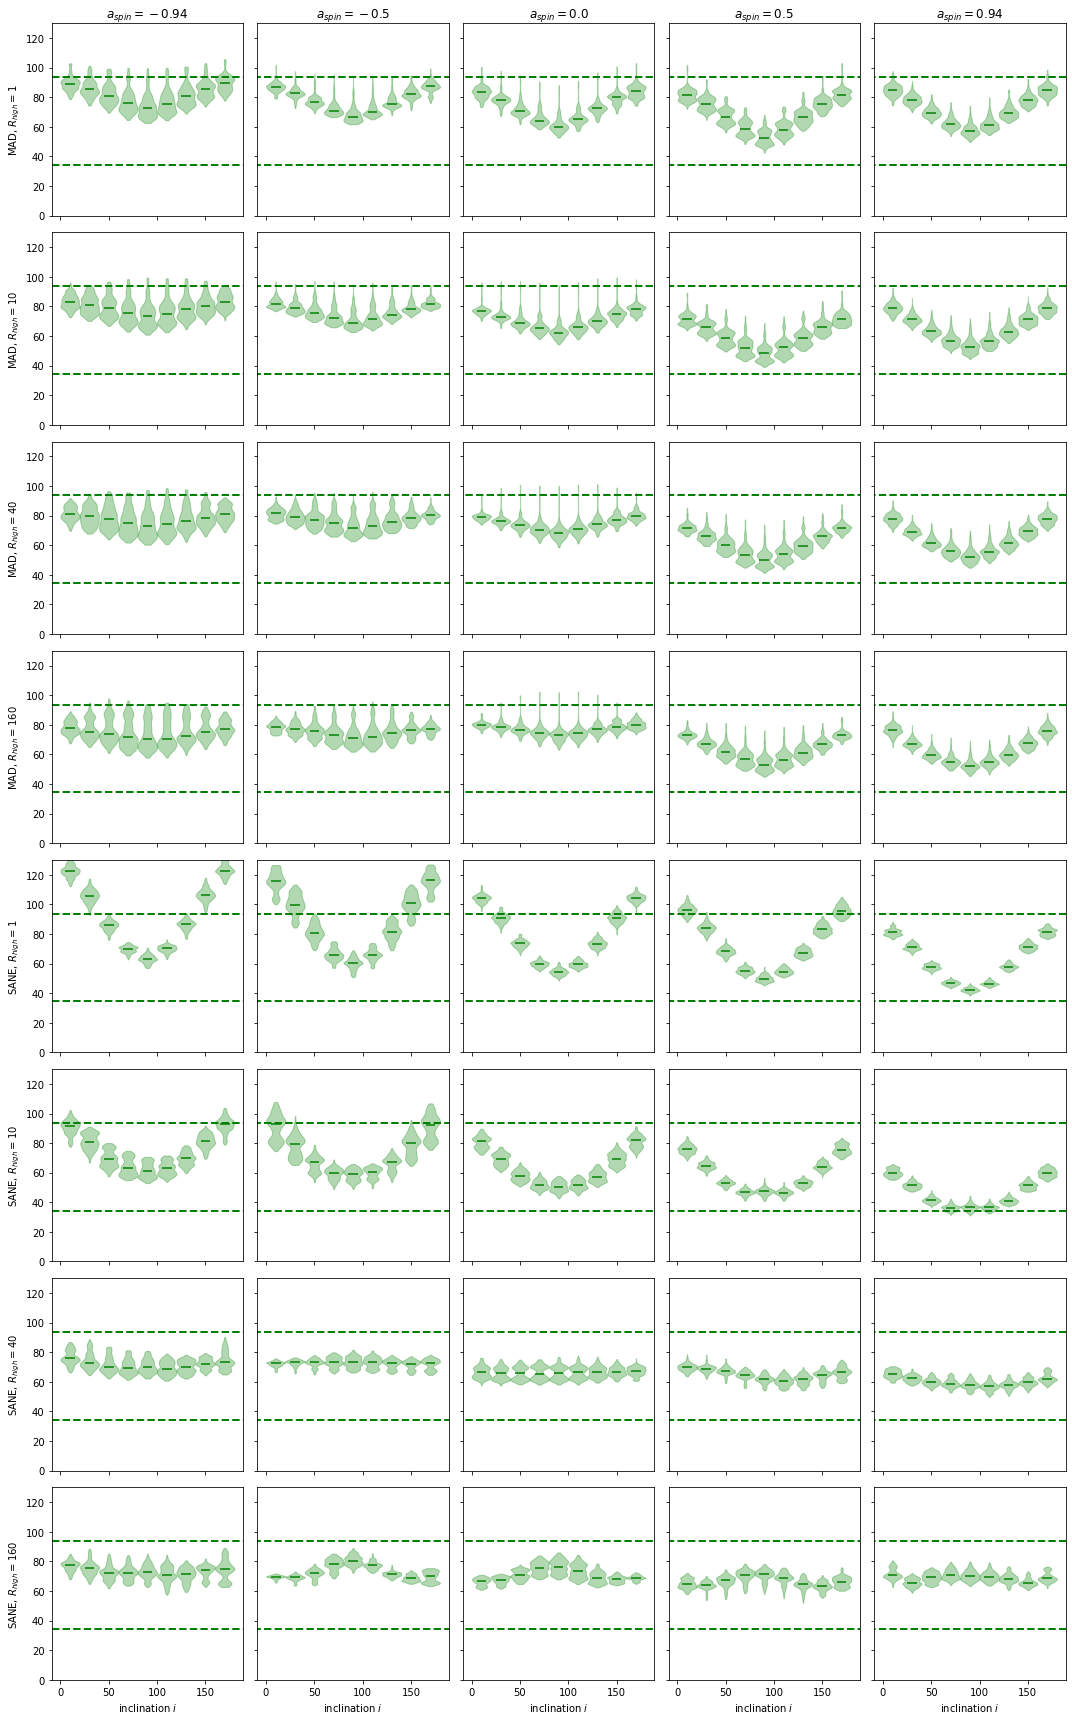

In [11]:
# choose only one window
winselect = 3

for freq in ['230GHz']:

    fig, axes = plt.subplots(8, 5, figsize=(15,24), sharex=True, sharey=True)
    color = 'g'
    for c, a in enumerate(aspin):
        for r1, m in enumerate(mag):
            for r2, Rh in enumerate(Rhigh):
                #print(a, m, Rh)
                r = r1 * 4 + r2

                for w in [winselect]:
                #for w in win:
                    sel = pf(freq=freq)(aspin=a)(mag=m)(Rhigh=Rh)(win=w)
                    if len(sel) != 9:
                        print('WARNING: too many matchingn tables')
                    dists = [np.sqrt(0.5*(getdist(sel(inc=i).path.iloc[0], 'major_FWHM')**2 + 
                                          getdist(sel(inc=i).path.iloc[0], 'minor_FWHM')**2))
                             for i in inc]
                    violin_parts = axes[r][c].violinplot(dists, positions=inc, widths=20, showmedians=True,showextrema=False)
                    for pc in violin_parts['bodies']:
                        pc.set_facecolor(color)
                        pc.set_edgecolor(color)
                    pc = violin_parts['cmedians']
                    pc.set_facecolor(color)
                    pc.set_edgecolor(color)

                axes[r][c].axhline(eht_fwhm_upper_deblur,xmin=-10, xmax=10, 
                                   color=color,ls='--',alpha=1, linewidth=2)
                axes[r][c].axhline(eht_fwhm_lower_deblur,xmin=-10, xmax=10, 
                               color=color,ls='--',alpha=1, linewidth=2)

                for kk,distdat in enumerate(dists):
                    i = inc[kk]
                    
                    if np.median(distdat) > eht_fwhm_upper_deblur: 
                        print(f'{m} spin={a} Rhigh={Rh} inc={i} is too large!')
                    if np.median(distdat) < eht_fwhm_lower_deblur: 
                        print(f'{m} spin={a} Rhigh={Rh} inc={i} is too small!')
                        
                if r == 0:
                    axes[r][c].set_title(f'$a_{{spin}} = {a}$')
                elif r == 7:
                    axes[r][c].set_xlabel('inclination $i$')
                if c == 0:
                    axes[r][c].set_ylabel(f'{"MAD" if m == "M" else "SANE"}, $R_{{high}} = {Rh}$')

                axes[r][c].set_ylim([0,130])
    fig.tight_layout()
    fig.savefig(f'output/plot/sizeconstraint_opt2_Illinois_thermal_{freq}.pdf')

## Option 3: "Deblur" constraints, then use the major and minor axis sizes to "bracket" the "upper size"

In [12]:
#"Deblur" the upper and lower constraints along the baseline axis
eht_fwhm_upper_deblur = np.sqrt(eht_fwhm_upper**2 - scat_fwhm**2)
eht_fwhm_lower_deblur = np.sqrt(eht_fwhm_lower**2 - scat_fwhm**2)
print(eht_fwhm_upper,eht_fwhm_lower)
print(eht_fwhm_upper_deblur,eht_fwhm_lower_deblur)

95 38
93.61106914382127 34.380696128049614


For a given GRMHD snapshot, we don't know the sky orientation corresponding to the ~140 degree PA the EHT is measuring the size constraint along. The most conservative thing to do is option 1, where we just demand that the measurement lower limit must be smaller than a given frame major axis and that the measurement upper limit must be greater than a given frame minor axis. In option 2, we look at the (quadrature) mean size for each snapshot and insist that it falls inside the range allowed by the EHT measurement. 

S spin=-0.94 Rhigh=1 inc=10 fails!
S spin=-0.94 Rhigh=1 inc=70 fails!
S spin=-0.94 Rhigh=1 inc=90 fails!
S spin=-0.94 Rhigh=1 inc=110 fails!
S spin=-0.94 Rhigh=1 inc=170 fails!
S spin=-0.94 Rhigh=10 inc=50 fails!
S spin=-0.94 Rhigh=10 inc=70 fails!
S spin=-0.94 Rhigh=10 inc=90 fails!
S spin=-0.94 Rhigh=10 inc=110 fails!
S spin=-0.94 Rhigh=10 inc=130 fails!
S spin=-0.94 Rhigh=40 inc=10 fails!
S spin=-0.94 Rhigh=40 inc=30 fails!
S spin=-0.94 Rhigh=40 inc=50 fails!
S spin=-0.94 Rhigh=40 inc=70 fails!
S spin=-0.94 Rhigh=40 inc=90 fails!
S spin=-0.94 Rhigh=40 inc=110 fails!
S spin=-0.94 Rhigh=40 inc=130 fails!
S spin=-0.94 Rhigh=40 inc=150 fails!
M spin=-0.5 Rhigh=160 inc=10 fails!
M spin=-0.5 Rhigh=160 inc=170 fails!
S spin=-0.5 Rhigh=1 inc=70 fails!
S spin=-0.5 Rhigh=1 inc=90 fails!
S spin=-0.5 Rhigh=1 inc=110 fails!
S spin=-0.5 Rhigh=1 inc=170 fails!
S spin=-0.5 Rhigh=10 inc=50 fails!
S spin=-0.5 Rhigh=10 inc=70 fails!
S spin=-0.5 Rhigh=10 inc=90 fails!
S spin=-0.5 Rhigh=10 inc=110 fails

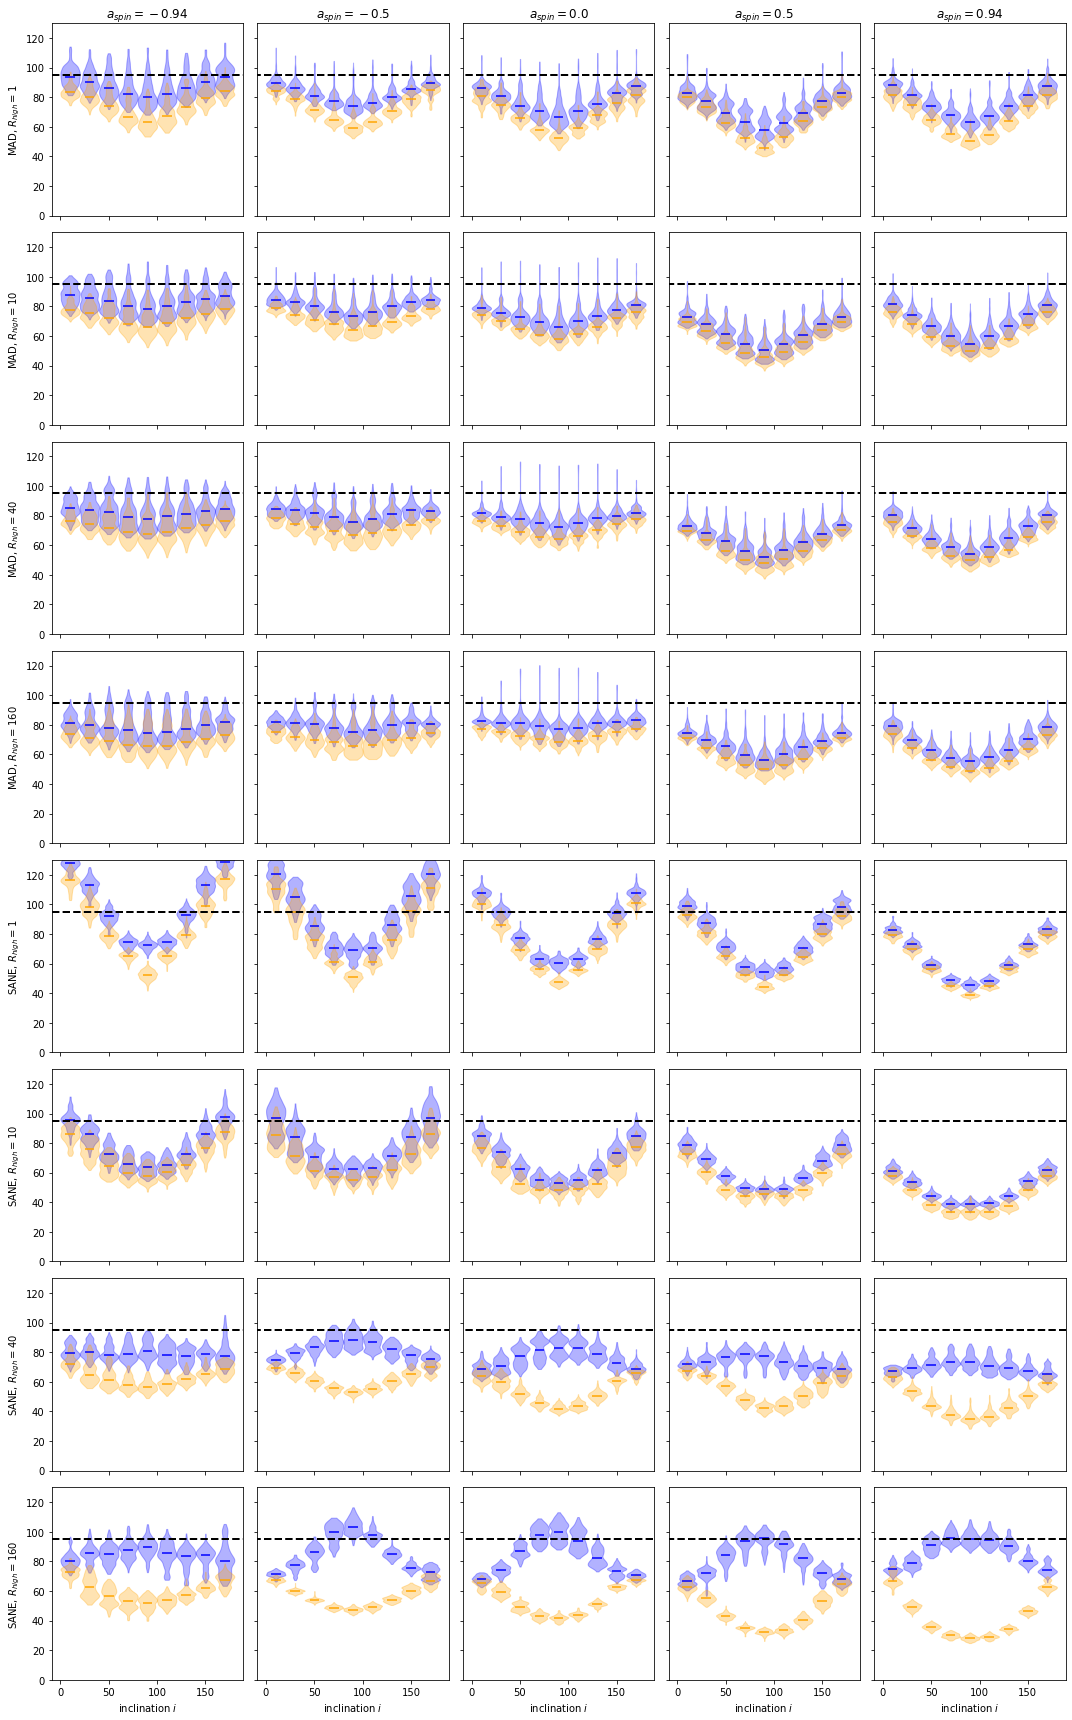

In [13]:
# choose only one window
winselect = 3
for dist in ['both']:

    for freq in ['230GHz']:

        fig, axes = plt.subplots(8, 5, figsize=(15,24), sharex=True, sharey=True)

        for c, a in enumerate(aspin):
            for r1, m in enumerate(mag):
                for r2, Rh in enumerate(Rhigh):
                    #print(a, m, Rh)
                    r = r1 * 4 + r2

                    color='black'
                    axes[r][c].axhline(eht_fwhm_upper,xmin=-10, xmax=10, 
                                       color=color,ls='--',alpha=1, linewidth=2)
                    
                    for w in [winselect]:
                    #for w in win:
                        sel = pf(freq=freq)(aspin=a)(mag=m)(Rhigh=Rh)(win=w)
                        if len(sel) != 9:
                            print('WARNING: too many matchingn tables')

                        dists_major = [getdist(sel(inc=i).path.iloc[0], 'major_FWHM') for i in inc]
                        dists_minor = [getdist(sel(inc=i).path.iloc[0], 'minor_FWHM') for i in inc]

                        for kk, i in enumerate(inc):
                            i = inc[kk]
                            distdata_major = dists_major[kk]
                            distdata_minor = dists_minor[kk]
                            if not (np.min(distdata_minor) < eht_fwhm_upper < np.max(distdata_major)):
                                print(f'{m} spin={a} Rhigh={Rh} inc={i} fails!')

                        color='blue'
                        violin_parts = axes[r][c].violinplot(dists_major, positions=inc, widths=20, showmedians=True, showextrema=False)
                        for pc in violin_parts['bodies']:
                            pc.set_facecolor(color)
                            pc.set_edgecolor(color)
                        pc = violin_parts['cmedians']
                        pc.set_facecolor(color)
                        pc.set_edgecolor(color)
                        
                        color='orange'
                        violin_parts = axes[r][c].violinplot(dists_minor, positions=inc, widths=20, showmedians=True, showextrema=False)
                        for pc in violin_parts['bodies']:
                            pc.set_facecolor(color)
                            pc.set_edgecolor(color)
                        pc = violin_parts['cmedians']
                        pc.set_facecolor(color)
                        pc.set_edgecolor(color)

                    if r == 0:
                        axes[r][c].set_title(f'$a_{{spin}} = {a}$')
                    elif r == 7:
                        axes[r][c].set_xlabel('inclination $i$')
                    if c == 0:
                        axes[r][c].set_ylabel(f'{"MAD" if m == "M" else "SANE"}, $R_{{high}} = {Rh}$')

                    axes[r][c].set_ylim([0,130])
 
        fig.tight_layout()
        fig.savefig(f'output/plot/sizeconstraint_opt1_{dist}_Illinois_thermal_{freq}.pdf')